In [136]:
import arff
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM,Dense, Dropout,Input,concatenate
from keras.models import Model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [35]:
from sklearn import preprocessing

### Load Dataset
open file ,grab data and convert data set into Pandas DataFrame

In [36]:
#inport dataset from arff file
fp = open('EEG_Eye_State.arff','r')
data = arff.load(fp)

In [39]:
#convert it into dataframe'
data_array = np.array(data['data'])
columns = [data['attributes'][x][0] for x in range(len(data['attributes']))]
df = pd.DataFrame(data_array,columns=[columns]).astype('float64')


(14980, 15)
['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4', 'eyeDetection']
       AF3       F7       F3      FC5       T7       P7       O1       O2  \
0  4329.23  4009.23  4289.23  4148.21  4350.26  4586.15  4096.92  4641.03   
1  4324.62  4004.62  4293.85  4148.72  4342.05  4586.67  4097.44  4638.97   
2  4327.69  4006.67  4295.38  4156.41  4336.92  4583.59  4096.92  4630.26   
3  4328.72  4011.79  4296.41  4155.90  4343.59  4582.56  4097.44  4630.77   
4  4326.15  4011.79  4292.31  4151.28  4347.69  4586.67  4095.90  4627.69   
5  4321.03  4004.62  4284.10  4153.33  4345.64  4587.18  4093.33  4616.92   
6  4319.49  4001.03  4280.51  4151.79  4343.59  4584.62  4089.74  4615.90   
7  4325.64  4006.67  4278.46  4143.08  4344.10  4583.08  4087.18  4614.87   
8  4326.15  4010.77  4276.41  4139.49  4345.13  4584.10  4091.28  4608.21   
9  4326.15  4011.28  4276.92  4142.05  4344.10  4582.56  4092.82  4608.72   

        P8       T8      FC6       

#### Describe feature of data set
(Count,Mean,standers_deviation,minimum,maximum,quatiels)

In [43]:
df.describe()

,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,eyeDetection
count,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000
mean,4321.917777,4009.767694,4264.022433,4164.946326,4341.741075,4644.022379,4110.400160,4616.056904,4218.826610,4231.316200,4202.456900,4279.232774,4615.205336,4416.435832,0.448798
std,2492.072174,45.941672,44.428052,5216.404632,34.738821,2924.789537,4600.926543,29.292603,2136.408523,38.050903,37.785981,41.544312,1208.369958,5891.285043,0.497388
min,1030.770000,2830.770000,1040.000000,2453.330000,2089.740000,2768.210000,2086.150000,4567.180000,1357.950000,1816.410000,3273.330000,2257.950000,86.666700,1366.150000,0.000000
25%,4280.510000,3990.770000,4250.260000,4108.210000,4331.790000,4611.790000,4057.950000,4604.620000,4190.770000,4220.510000,4190.260000,4267.690000,4590.770000,4342.050000,0.000000
50%,4294.360000,4005.640000,4262.560000,4120.510000,4338.970000,4617.950000,4070.260000,4613.330000,4199.490000,4229.230000,4200.510000,4276.920000,4603.080000,4354.870000,0.000000
75%,4311.790000,4023.080000,4270.770000,4132.310000,4347.180000,4626.670000,4083.590000,4624.100000,4209.230000,4239.490000,4211.280000,4287.180000,4617.440000,4372.820000,1.000000
max,309231.000000,7804.620000,6880.510000,642564.000000,6474.360000,362564.000000,567179.000000,7264.100000,265641.000000,6674.360000,6823.080000,7002.560000,152308.000000,715897.000000,1.000000


### Prepare data set for LSTM 1 
(one output from 10 nodes (timesteps))

In [445]:
 def dataColectionShift(data,steps):
    X = pd.DataFrame()
    Y = pd.DataFrame()
    columnNames = data.columns
    for i in range(steps,0,-1):
        for col in columnNames:
            X[col[0]+"_t-"+str(i)] = data.shift(i - (steps+1))[col]
    for col in columnNames:
        Y[col[0]+"t"] = data.shift(-(steps))[col]
    X = X.dropna()
    Y = Y.dropna()
    return X,Y

In [449]:
eye_x_1,y = dataColectionShift(df['eyeDetection'],10)
eeg_x,eeg_y = dataColectionShift(df.iloc[:,0:14],10)

### noemalize data set
eye_x = preprocessing.normalize(eye_x_1)
eeg_x = preprocessing.normalize(eeg_x)

eye_x = np.reshape(eye_x,(eye_x.shape[0],10,1))
eeg_x = np.reshape(eeg_x,(eeg_x.shape[0],10,14))
print(eye_x.shape,y.shape)

(14970, 10, 1) (14970, 1)


#### spliting dataset into training ,Testing and Validation

 testing Trainig Split

In [610]:
#eye data classification
eye_train_x,eye_test_x,eye_train_y,eye_test_y = train_test_split(eye_x,y,test_size = 0.2,random_state = 1024,shuffle=False)

#eeg data classification
eeg_train_x,eeg_test_x,eeg_train_y,eeg_test_y = train_test_split(eeg_x, eeg_y,test_size = 0.2,random_state = 1024,shuffle=False) 


  Training ,Validation Split

In [451]:
#eye dagta split
eye_trainX, eye_valX, eye_trainY, eye_valY = train_test_split(eye_train_x,eye_train_y,test_size = 0.1,random_state = 1024,shuffle=False)

#eeg data split
eeg_trainX, eeg_valX, eeg_trainY, eeg_valY = train_test_split(eeg_train_x,eeg_train_y,test_size = 0.1,random_state = 1024,shuffle=False)


### Prepare data for LSTM model 2
( 10 output Predition from 10 time steps)

In [602]:
def dataColectionShift2(data,step):
    dataY = data.shift(-1)
    
    data = np.array(data)
    dataY = np.array(dataY)
    x = []
    y = []
    for k in range(0,data.shape[0]-step):
        x.append(data[k:k+step])
    for k in range(0,dataY.shape[0]-step):
        y.append(dataY[k:k+step])
    x = np.array(x)
    y = np.array(y)
    
    return x,y

In [603]:
eye_x_2,y_2 = dataColectionShift2(df['eyeDetection'],10)
eeg_x_2,eeg_y_2 = dataColectionShift2(df.iloc[:,0:14],10)
y_2 = y_2.reshape(y_2.shape[0],10)

In [604]:
print(eye_x_2.shape,y_2.shape)
print(eeg_x_2.shape,eeg_y_2.shape)

(14970, 10, 1) (14970, 10)
(14970, 10, 14) (14970, 10, 14)


In [605]:
#eye_x_2 = preprocessing.normalize(eye_x_2.reshape((eye_x_2.shape[0],10))).reshape((eye_x_2.shape[0],10,1))
#eeg_x_2 =  preprocessing.normalize(eeg_x_2.reshape((eeg_x_2.shape[0],140))).reshape((eeg_x_2.shape[0],10,14))

#### Data spliting proccess forLSTM model 2

In [606]:
#eye data classification for model 2
eye_train_x_2,eye_test_x_2,eye_train_y_2,eye_test_y_2 = train_test_split(eye_x_2,y_2,test_size = 0.2,random_state = 1024,shuffle=False)

#eeg data classification for model 2
eeg_train_x_2,eeg_test_x_2,eeg_train_y_2,eeg_test_y_2 = train_test_split(eeg_x_2, eeg_y_2,test_size = 0.2,random_state = 1024,shuffle=False) 


In [607]:
eeg_train_x_2.shape

(11976, 10, 14)

validation data split

In [608]:
#eye dagta split
eye_trainX_2, eye_valX_2, eye_trainY_2, eye_valY_2 = train_test_split(eye_train_x_2,eye_train_y_2,test_size = 0.1,random_state = 1024,shuffle=False)

#eeg data split
eeg_trainX_2, eeg_valX_2, eeg_trainY_2, eeg_valY_2 = train_test_split(eeg_train_x_2,eeg_train_y_2,test_size = 0.1,random_state = 1024,shuffle=False)


In [609]:
eye_train_x_2.shape

(11976, 10, 1)

## Create model for LSTM model 1

In [551]:
#lstm layer for eye data
eye_input = Input(shape=(10,1),name="InputEye")
eye_lstm = LSTM(16,return_sequences = True)(eye_input)
eye_drop = Dropout(0.8)(eye_lstm)
eye_lstm_2 = LSTM(32)(eye_drop)
eye_drop_2 = Dropout(0.8)(eye_lstm_2)

#lstm for eeg data
eeg_input = Input(shape=(10,14),name='InputEeg')
eeg_lstm = LSTM(25,return_sequences=True)(eeg_input)
eeg_drop = Dropout(0.6)(eeg_lstm)
eeg_lstm_2 = LSTM(30)(eeg_drop)
eeg_drop_2 = Dropout(0.4)(eeg_lstm_2)

In [552]:
# dense layer for each lstm layers
eye_output = Dense(1,activation = 'tanh', name='eyeDense')(eye_drop_2)
eeg_output = Dense(1,activation = 'tanh', name='eegDense')(eeg_drop_2)

In [553]:
concat = concatenate([eye_output,eeg_output],axis=1)
output = Dense(1,activation = 'sigmoid',name = 'Output_sigmoid')(concat)

#create final model
model = Model(input = [eye_input,eeg_input],output = output)
print(model.summary())
print(model.output)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
InputEye (InputLayer)           (None, 10, 1)        0                                            
__________________________________________________________________________________________________
InputEeg (InputLayer)           (None, 10, 14)       0                                            
__________________________________________________________________________________________________
lstm_57 (LSTM)                  (None, 10, 16)       1152        InputEye[0][0]                   
__________________________________________________________________________________________________
lstm_59 (LSTM)                  (None, 10, 25)       4000        InputEeg[0][0]                   
__________________________________________________________________________________________________
dropout_55

C:\Users\Indika\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("Ou...)`
  """


### Output Size LSTM model 1

In [554]:
print (model.output.shape)

(?, 1)


##### Explaination of output
model give one out put for 10 timesteps.

In [459]:
#implement the model

In [460]:
model.compile(optimizer='adam', loss='binary_crossentropy',metrics=["accuracy"])
results = model.fit([eye_trainX, eeg_trainX], [eye_trainY], validation_data=([eye_valX,eeg_valX],eye_valY),
          epochs=10, batch_size=32)

Train on 10778 samples, validate on 1198 samples
Epoch 1/10
10778/10778 [==============================] - 13s 1ms/step - loss: 0.3270 - acc: 0.9265 - val_loss: 0.2030 - val_acc: 0.9950
Epoch 2/10
10778/10778 [==============================] - 6s 592us/step - loss: 0.1962 - acc: 0.9893 - val_loss: 0.1583 - val_acc: 0.9967
Epoch 3/10
10778/10778 [==============================] - 7s 608us/step - loss: 0.1563 - acc: 0.9905 - val_loss: 0.1257 - val_acc: 0.9975
Epoch 4/10
10778/10778 [==============================] - 7s 678us/step - loss: 0.1297 - acc: 0.9904 - val_loss: 0.1060 - val_acc: 0.9958
Epoch 5/10
10778/10778 [==============================] - 7s 642us/step - loss: 0.1085 - acc: 0.9915 - val_loss: 0.0863 - val_acc: 0.9975
Epoch 6/10
10778/10778 [==============================] - 7s 604us/step - loss: 0.0936 - acc: 0.9919 - val_loss: 0.0713 - val_acc: 0.9983
Epoch 7/10
10778/10778 [==============================] - 7s 605us/step - loss: 0.0826 - acc: 0.9917 - val_loss: 0.0606 - va

In [461]:
#loss plot for training result

## Analyse LSTM model 1

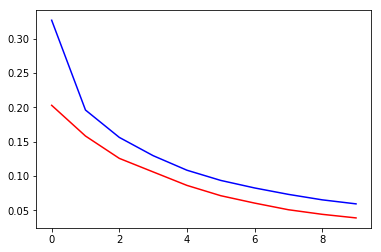

In [555]:
plt.plot(results.history['loss'],c='b')
plt.plot(results.history['val_loss'],c='r')
plt.show()

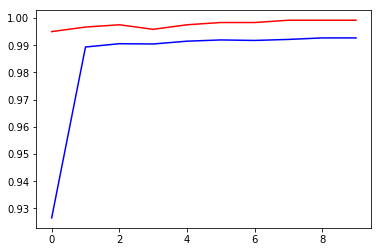

In [556]:
plt.plot(results.history['acc'],c='b')
plt.plot(results.history['val_acc'],c='r')
plt.show()

In [557]:
y_predict = model.predict([eye_test_x,eeg_test_x])

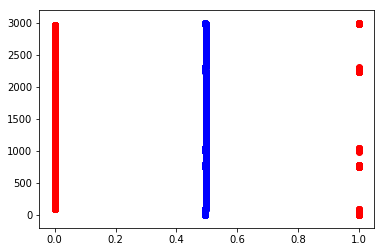

In [558]:
plt.scatter(y_predict,range(len(y_predict)),c='b')
plt.scatter(eye_test_y,range(len(eye_test_y)),c='r')
plt.show()
## blue dots show predict values
## red dots show expected values

#### discution for LSTM model 1 prection
According to the above graph ,we can see that the predictions are almost correct

## Create model for LSTM model 2

In [612]:
#lstm layer for eye data
eye_input_m2 = Input(shape=(10,1),name="InputEyeM2")
eye_lstm_m2 = LSTM(16,return_sequences = True)(eye_input_m2)
eye_drop_m2 = Dropout(0.8)(eye_lstm_m2)
eye_lstm2_m2 = LSTM(16,return_sequences = True)(eye_input_m2)
eye_drop_m2 = Dropout(0.8)(eye_lstm2_m2)
eye_lstm_2_m2 = LSTM(32)(eye_drop2_m2)
eye_drop_2_m2 = Dropout(0.8)(eye_lstm_2_m2)

#lstm for eeg data
eeg_input_m2 = Input(shape=(10,14),name='InputEegM2')
eeg_lstm_m2 = LSTM(25,return_sequences=True)(eeg_input_m2)
eeg_drop_m2 = Dropout(0.6)(eeg_lstm_m2)
eeg_lstm_2_m2 = LSTM(32)(eeg_drop_m2)
eeg_drop_2_m2 = Dropout(0.4)(eeg_lstm_2_m2)

In [613]:
# dense layer for each lstm layers
eye_output_m2 = Dense(1,activation = 'tanh', name='eyeDenseM2')(eye_drop_2_m2)
eeg_output_m2 = Dense(1,activation = 'tanh', name='eegDenseM2')(eeg_drop_2_m2)

In [629]:
concat_m2 = concatenate([eye_output_m2,eeg_output_m2],axis=1)
concat_m2 = Dense(1,activation = 'sigmoid')(concat_m2)
output_m2 = Dense(10, activation='sigmoid',name ='Output_sigmoid_m2')(concat_m2)

#create final model
model = Model(input = [eye_input_m2,eeg_input_m2],output = output_m2)
print(model.summary())
print(model.output)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
InputEyeM2 (InputLayer)         (None, 10, 1)        0                                            
__________________________________________________________________________________________________
InputEegM2 (InputLayer)         (None, 10, 14)       0                                            
__________________________________________________________________________________________________
lstm_77 (LSTM)                  (None, 10, 16)       1152        InputEyeM2[0][0]                 
__________________________________________________________________________________________________
lstm_79 (LSTM)                  (None, 10, 25)       4000        InputEegM2[0][0]                 
__________________________________________________________________________________________________
dropout_75

C:\Users\Indika\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("Ou...)`
  


In [630]:
model.compile(optimizer='adam', loss='binary_crossentropy',metrics=["accuracy"])
results = model.fit([eye_trainX_2, eeg_trainX_2], [eye_trainY_2], validation_data=([eye_valX_2,eeg_valX_2],eye_valY_2),
          epochs=10, batch_size=60)

Train on 10778 samples, validate on 1198 samples
Epoch 1/10
10778/10778 [==============================] - 13s 1ms/step - loss: 0.6985 - acc: 0.4931 - val_loss: 0.6908 - val_acc: 0.5447
Epoch 2/10
10778/10778 [==============================] - 4s 409us/step - loss: 0.6934 - acc: 0.4656 - val_loss: 0.6822 - val_acc: 0.5857
Epoch 3/10
10778/10778 [==============================] - 4s 401us/step - loss: 0.6922 - acc: 0.5036 - val_loss: 0.6754 - val_acc: 0.7316
Epoch 4/10
10778/10778 [==============================] - 4s 399us/step - loss: 0.6861 - acc: 0.5162 - val_loss: 0.6499 - val_acc: 0.7316
Epoch 5/10
10778/10778 [==============================] - 5s 447us/step - loss: 0.6602 - acc: 0.5340 - val_loss: 0.5986 - val_acc: 0.78490s - loss: 0.6603 - acc: 0.533
Epoch 6/10
10778/10778 [==============================] - 5s 467us/step - loss: 0.6147 - acc: 0.6604 - val_loss: 0.5433 - val_acc: 0.8659
Epoch 7/10
10778/10778 [==============================] - 5s 441us/step - loss: 0.5633 - acc: 

## LSTM model 2 analysys

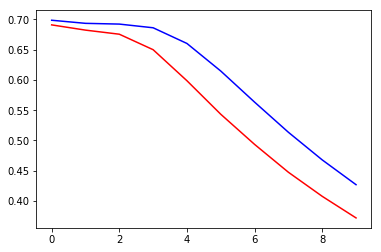

In [631]:
plt.plot(results.history['loss'],c='b')
plt.plot(results.history['val_loss'],c='r')
plt.show()

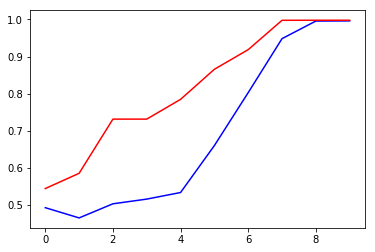

In [632]:
plt.plot(results.history['acc'],c='b')
plt.plot(results.history['val_acc'],c='r')
plt.show()

In [633]:
#loss values are decreased and accuracy became increased....so we can assume that model corectly predicting sequances

In [638]:
y_predict_2 = model.predict([eye_test_x_2,eeg_test_x_2])

In [646]:
y_predict_2[:,0].shape

(2994,)

In [645]:
range(len(y_predict_2))

range(0, 2994)

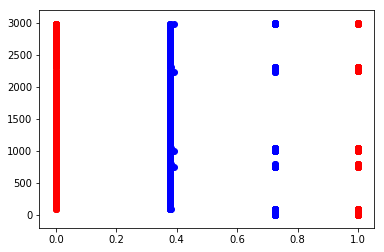

In [653]:
plt.scatter(y_predict_2[:,0],range(len(y_predict_2)),c='b')
plt.scatter(eye_test_y_2[:,0],range(len(eye_test_y_2)),c='r')
plt.show()
## blue dots show predict values
## red dots show expected values

In [654]:
## in the above plots ,blue lines are generated by the network more acurately like expected values..... 